In [13]:
import os 
import random
import paddle
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from paddle.vision import datasets, transforms


In [14]:
demo_ds = datasets.MNIST(mode='train')

demo_ds first image label:  [5]
image size: (28, 28)


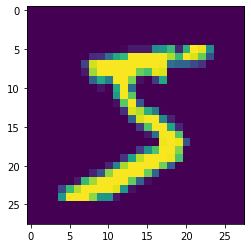

In [15]:
print("demo_ds first image label: ", demo_ds[0][1])
print("image size:", demo_ds[0][0].size)
plt.imshow(demo_ds[0][0])

In [16]:
dataset = datasets.MNIST(mode='train', 
                         transform=transforms.Compose([
                             transforms.Resize((32, 32)), 
                             transforms.Normalize([127.5], [127.5])
                         ])
                        )
dataloader = paddle.io.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [17]:
for data in dataloader:
    print("batch img:", data[0].shape)
    print("batch label:", data[1].shape)
    break

batch img: [32, 1, 32, 32]
batch label: [32, 1]


In [18]:
# 参数模块初始化
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_val = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_val)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_val = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_val)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_val = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_val)
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0., 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

In [19]:
# Generator Code
class Generator(nn.Layer):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            # input is Z, [B, 100, 1, 1] -> [B, 64*4, 4, 4]
            nn.Conv2DTranspose(100, 64*4, kernel_size=4, stride=1, padding=0, bias_attr=False),
            nn.BatchNorm2D(64*4),
            nn.ReLU(),
            
            # [B, 64*4, 4, 4] -> [B, 64*2, 8, 8]
            nn.Conv2DTranspose(64*4, 64*2, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.BatchNorm2D(64*2),
            nn.ReLU(),
            
            # [B, 64*2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose(64*2, 64, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(),
            
            # [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose(64, 1, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.Tanh() # 将生成的图片像素值归一化到 （-1,1）之间，与训练数据进入训练网络之前的归一化操作（一般缩放到 -1 到 1之间）对应
        )
    
    def forward(self, x):
        return self.gen(x)
        

In [20]:
netG = Generator()
#netG.apply(weights_init)

In [21]:
class Discriminator(nn.Layer):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.LeakyReLU(0.2),
            
            # [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 128, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.BatchNorm2D(128),
            nn.LeakyReLU(0.2),
            
            # [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(128, 256, kernel_size=4, stride=2, padding=1, bias_attr=False),
            nn.BatchNorm2D(256),
            nn.LeakyReLU(0.2),
            
            # [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(256, 1, kernel_size=4, stride=1, padding=0, bias_attr=False),
            
            # DCGAN 打开注释（判别器使用的是二分类交叉熵计算损失）； LSGAN 关闭注释（判别器使用的是最小二乘计算损失）
            #nn.Sigmoid()
        )
    def forward(self, x):
        return self.dis(x)

In [22]:
netD = Discriminator()
#netD.apply(weights_init)

In [23]:
# training

# Initialize BCELoss function（DCGAN）
# loss = nn.BCELoss()

# MSELoss (LSGAN)
loss = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = paddle.optimizer.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = paddle.optimizer.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)

Epoch ID=0 Batch ID=0 

 D-Loss=1.288975715637207 G-Loss=2.0957655906677246


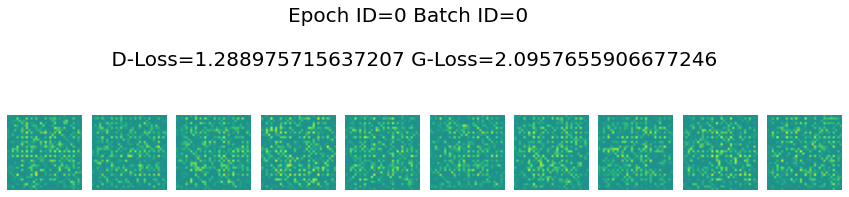

Epoch ID=0 Batch ID=100 

 D-Loss=0.6208609342575073 G-Loss=0.22350233793258667


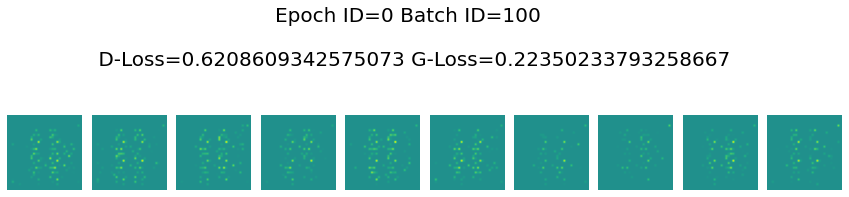

Epoch ID=0 Batch ID=200 

 D-Loss=0.21227428317070007 G-Loss=1.6616121530532837


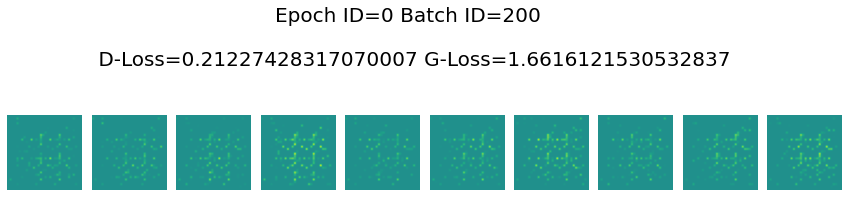

Epoch ID=0 Batch ID=300 

 D-Loss=1.5833711624145508 G-Loss=7.235698699951172


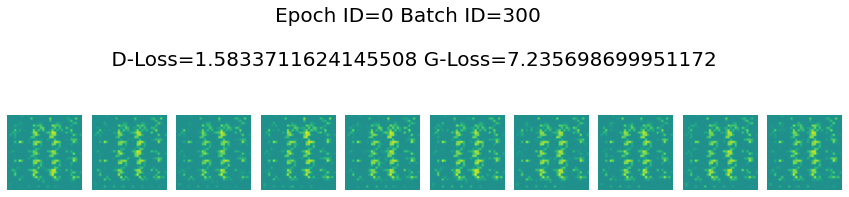

Epoch ID=0 Batch ID=400 

 D-Loss=0.1052640974521637 G-Loss=0.9897439479827881


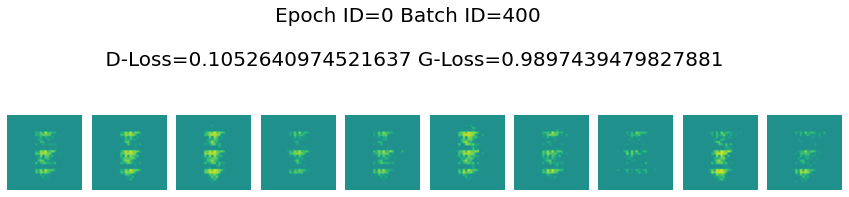

Epoch ID=0 Batch ID=500 

 D-Loss=0.25629308819770813 G-Loss=0.48712557554244995


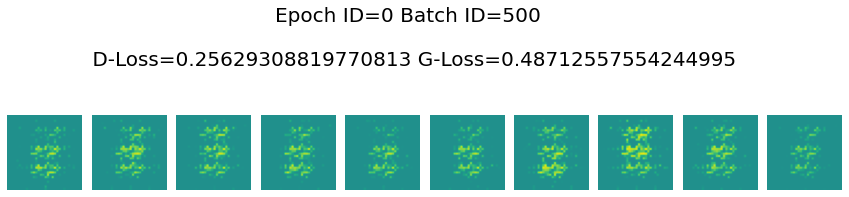

Epoch ID=0 Batch ID=600 

 D-Loss=0.7486273646354675 G-Loss=3.649944305419922


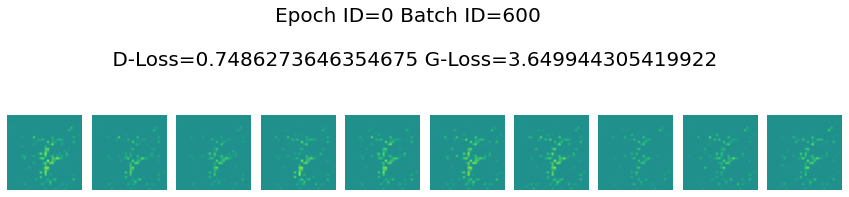

Epoch ID=0 Batch ID=700 

 D-Loss=0.8386117815971375 G-Loss=5.260869979858398


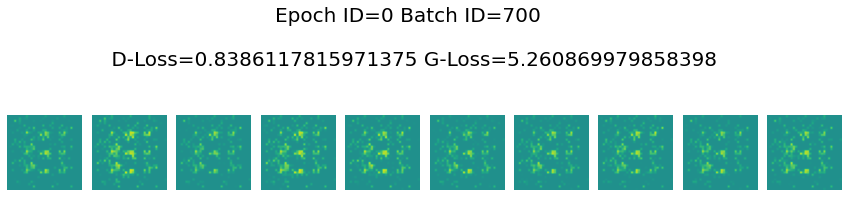

Epoch ID=0 Batch ID=800 

 D-Loss=0.22601750493049622 G-Loss=1.9061598777770996


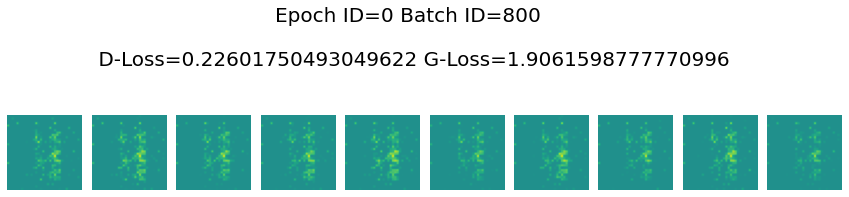

Epoch ID=0 Batch ID=900 

 D-Loss=0.1506054401397705 G-Loss=1.7143586874008179


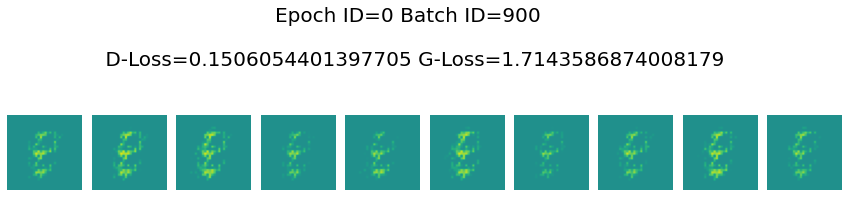

Epoch ID=0 Batch ID=1000 

 D-Loss=0.1803344041109085 G-Loss=0.745677649974823


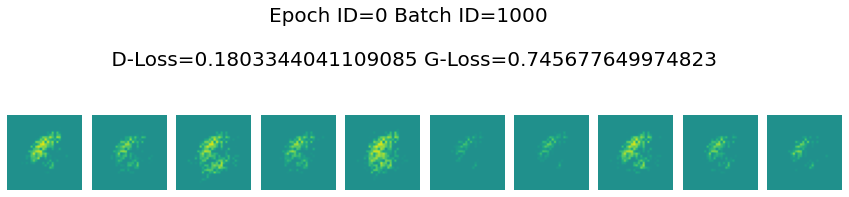

Epoch ID=0 Batch ID=1100 

 D-Loss=2.0646796226501465 G-Loss=0.15593257546424866


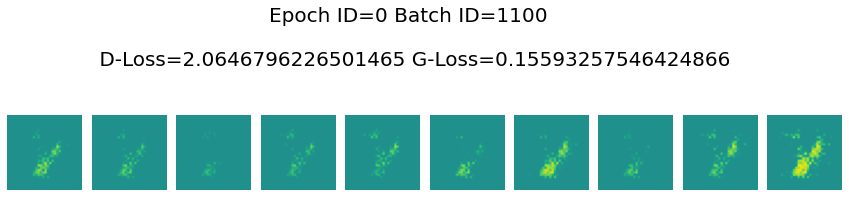

Epoch ID=0 Batch ID=1200 

 D-Loss=0.15564779937267303 G-Loss=0.7547092437744141


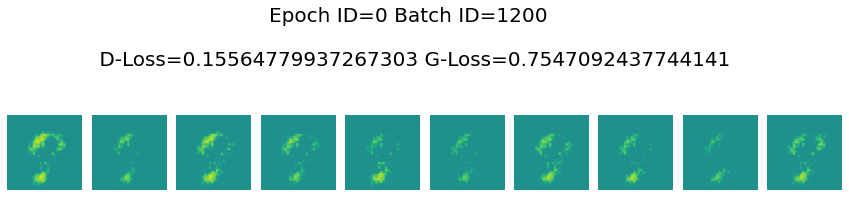

Epoch ID=0 Batch ID=1300 

 D-Loss=0.10950786620378494 G-Loss=0.9877122640609741


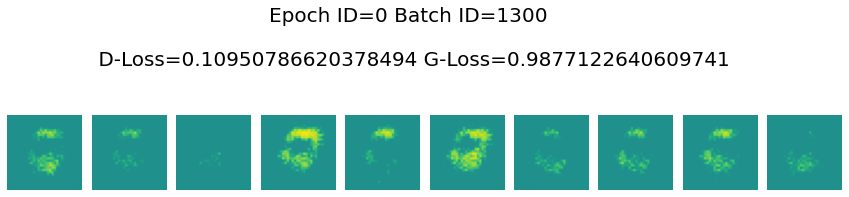

Epoch ID=0 Batch ID=1400 

 D-Loss=0.09667667746543884 G-Loss=0.8640087842941284


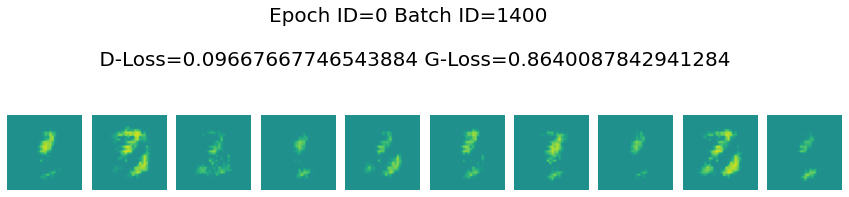

Epoch ID=0 Batch ID=1500 

 D-Loss=0.10754505544900894 G-Loss=0.737669825553894


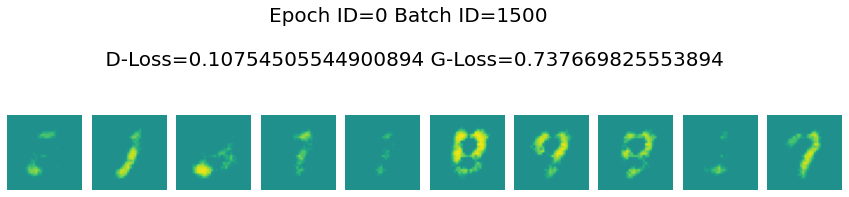

Epoch ID=0 Batch ID=1600 

 D-Loss=0.1470772624015808 G-Loss=0.806060791015625


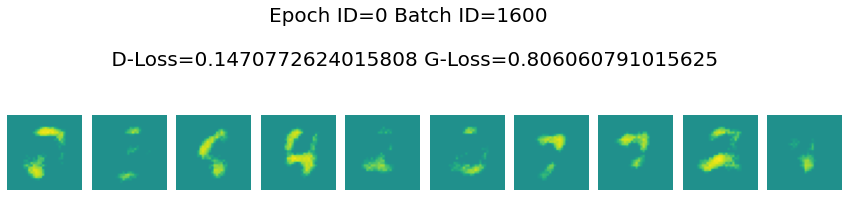

Epoch ID=0 Batch ID=1700 

 D-Loss=0.1538289338350296 G-Loss=1.0776513814926147


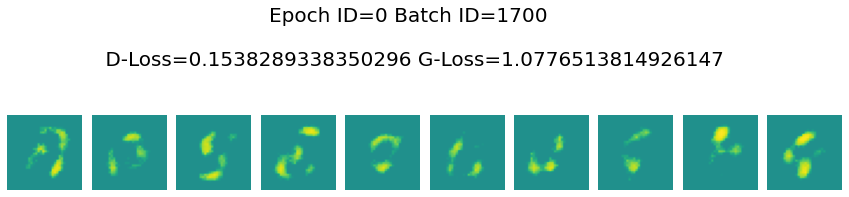

Epoch ID=0 Batch ID=1800 

 D-Loss=0.127668559551239 G-Loss=0.7114469408988953


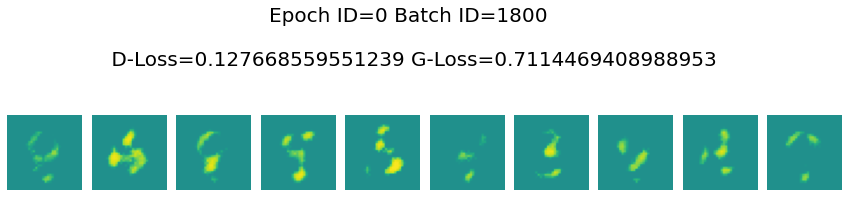

Epoch ID=1 Batch ID=0 

 D-Loss=0.08509013801813126 G-Loss=0.6532073020935059


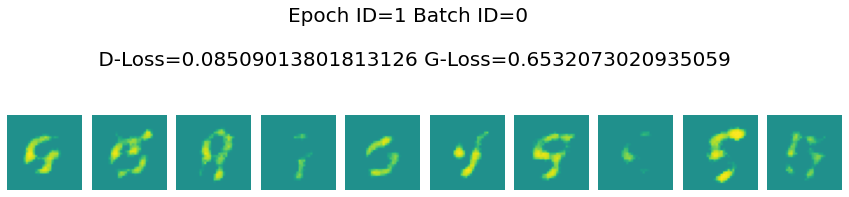

Epoch ID=1 Batch ID=100 

 D-Loss=0.059056248515844345 G-Loss=0.8700670003890991


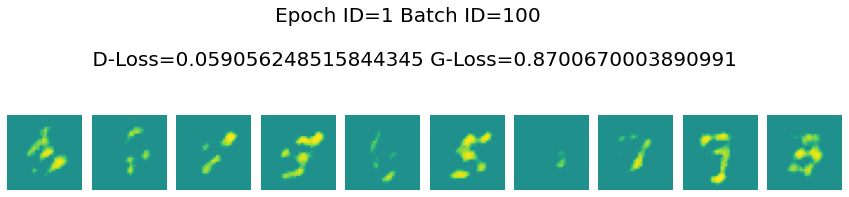

Epoch ID=1 Batch ID=200 

 D-Loss=0.10121272504329681 G-Loss=0.7827794551849365


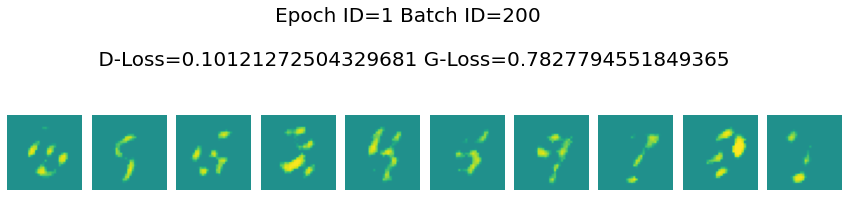

Epoch ID=1 Batch ID=300 

 D-Loss=0.07912814617156982 G-Loss=1.0793298482894897


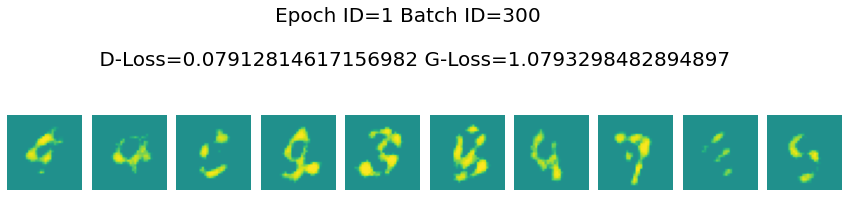

Epoch ID=1 Batch ID=400 

 D-Loss=0.1332831084728241 G-Loss=1.0929217338562012


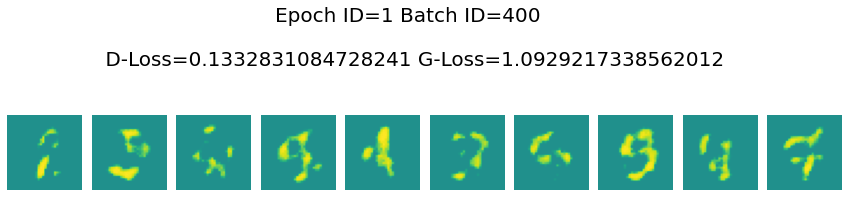

Epoch ID=1 Batch ID=500 

 D-Loss=0.09957664459943771 G-Loss=0.6139823198318481


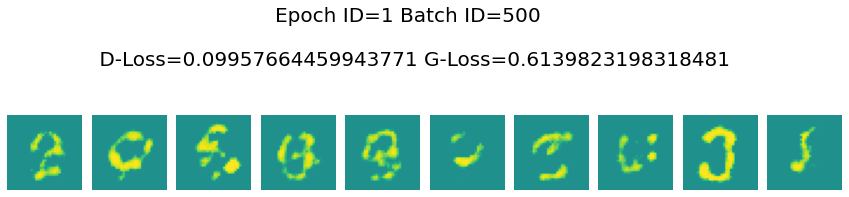

Epoch ID=1 Batch ID=600 

 D-Loss=0.09511154890060425 G-Loss=0.6764681339263916


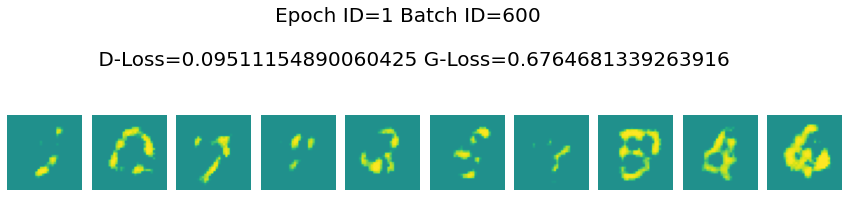

Epoch ID=1 Batch ID=700 

 D-Loss=0.10384131968021393 G-Loss=0.7439274787902832


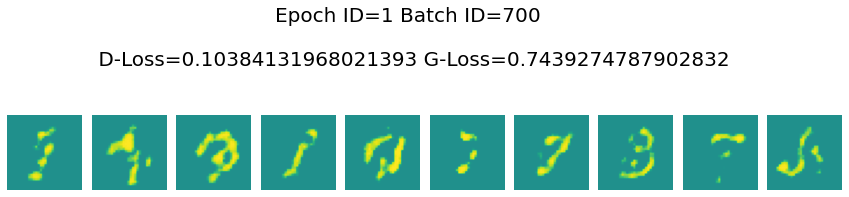

Epoch ID=1 Batch ID=800 

 D-Loss=0.26896560192108154 G-Loss=0.8506242036819458


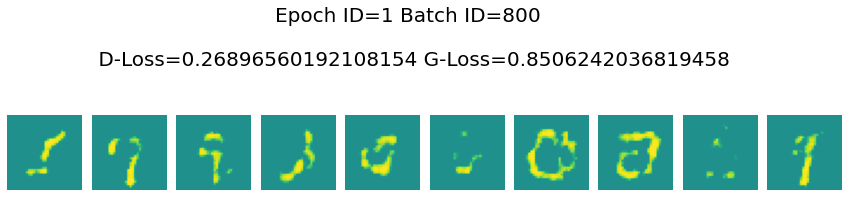

Epoch ID=1 Batch ID=900 

 D-Loss=0.29585033655166626 G-Loss=1.3501224517822266


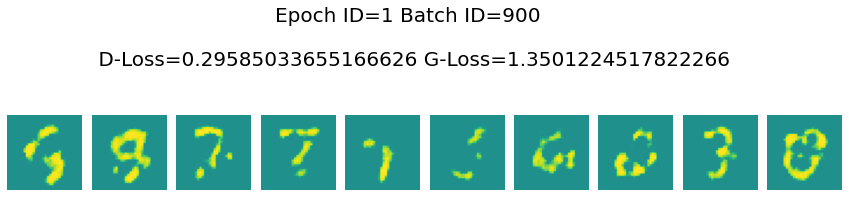

Epoch ID=1 Batch ID=1000 

 D-Loss=0.10276944935321808 G-Loss=0.7771797180175781


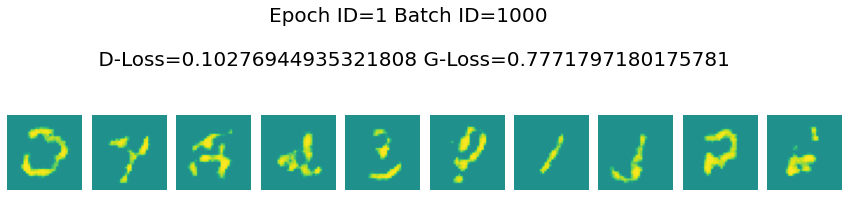

Epoch ID=1 Batch ID=1100 

 D-Loss=0.35473135113716125 G-Loss=0.17315980792045593


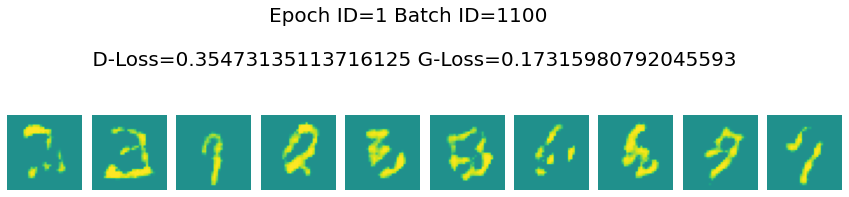

Epoch ID=1 Batch ID=1200 

 D-Loss=0.3980913758277893 G-Loss=1.377873420715332


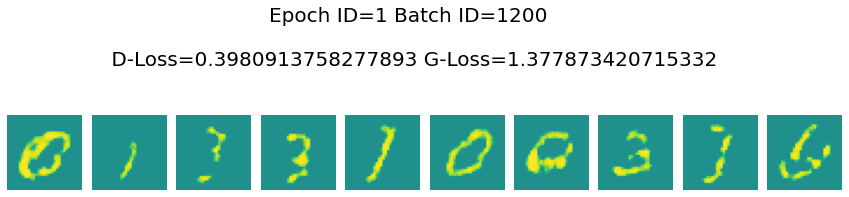

Epoch ID=1 Batch ID=1300 

 D-Loss=0.056014783680438995 G-Loss=0.6103087067604065


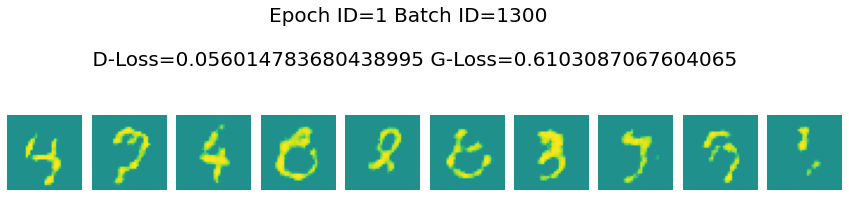

Epoch ID=1 Batch ID=1400 

 D-Loss=0.16039539873600006 G-Loss=0.902892529964447


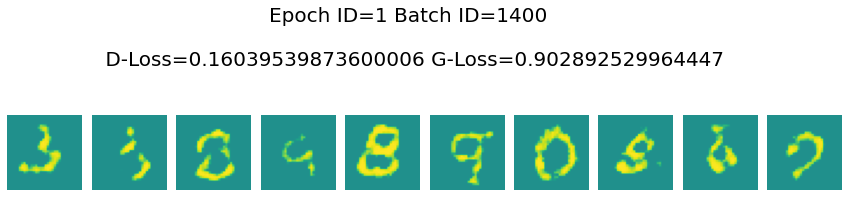

Epoch ID=1 Batch ID=1500 

 D-Loss=0.07022367417812347 G-Loss=0.9315069913864136


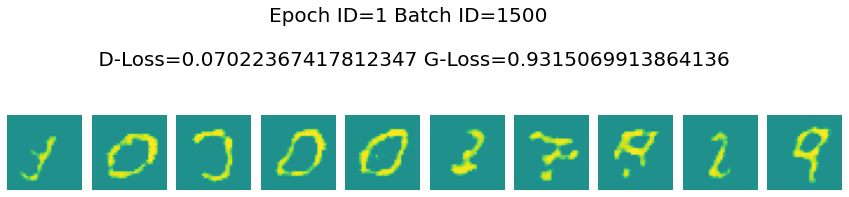

Epoch ID=1 Batch ID=1600 

 D-Loss=0.09902302920818329 G-Loss=0.6888761520385742


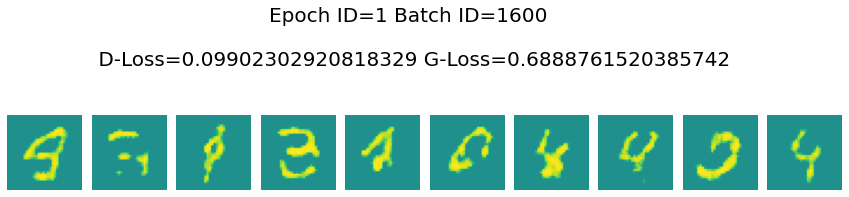

Epoch ID=1 Batch ID=1700 

 D-Loss=0.11370516568422318 G-Loss=0.3501819968223572


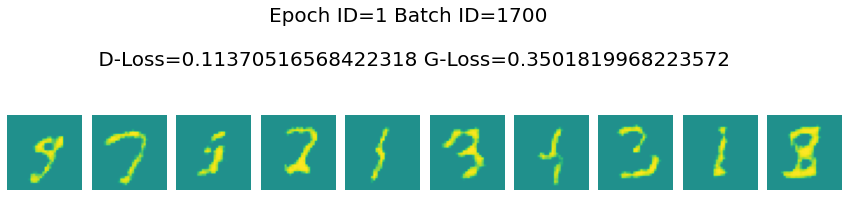

Epoch ID=1 Batch ID=1800 

 D-Loss=0.4297735393047333 G-Loss=0.29162663221359253


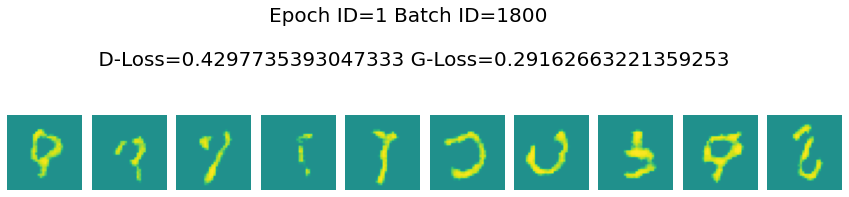

Epoch ID=2 Batch ID=0 

 D-Loss=0.22540734708309174 G-Loss=1.9513461589813232


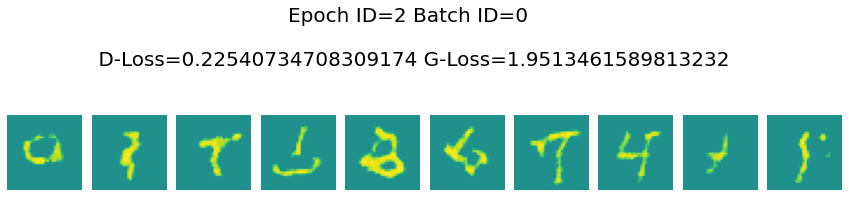

Epoch ID=2 Batch ID=100 

 D-Loss=0.24575112760066986 G-Loss=0.15093784034252167


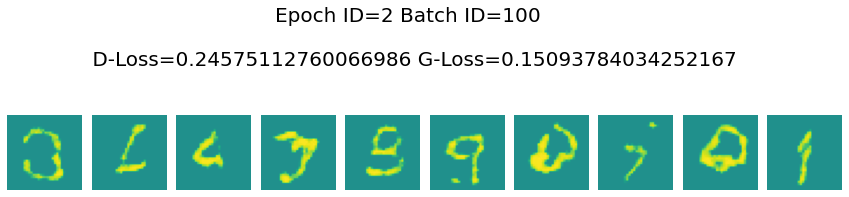

Epoch ID=2 Batch ID=200 

 D-Loss=0.23174113035202026 G-Loss=0.28520479798316956


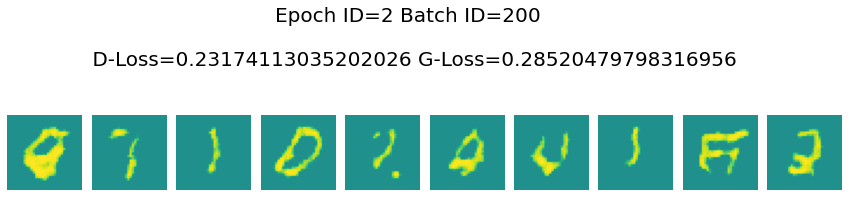

Epoch ID=2 Batch ID=300 

 D-Loss=1.3705873489379883 G-Loss=1.917403221130371


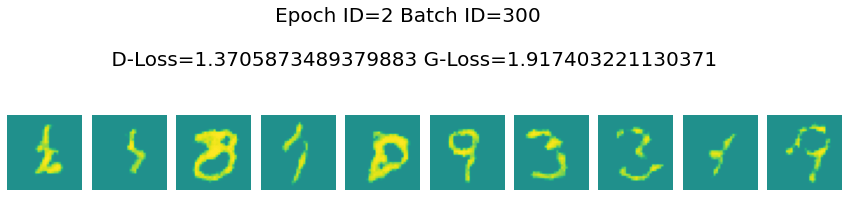

Epoch ID=2 Batch ID=400 

 D-Loss=0.3615689277648926 G-Loss=0.3253859281539917


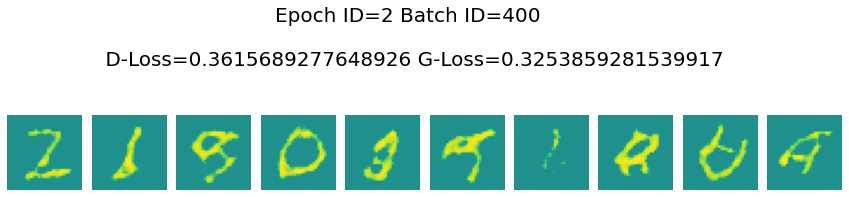

Epoch ID=2 Batch ID=500 

 D-Loss=0.25505390763282776 G-Loss=1.1889164447784424


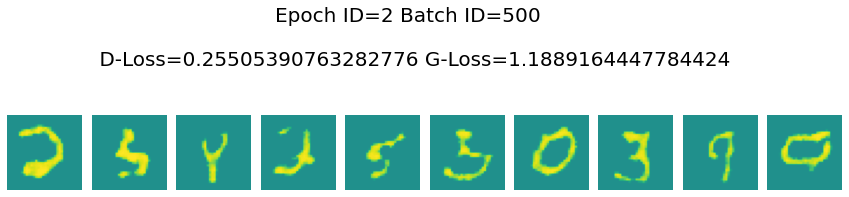

Epoch ID=2 Batch ID=600 

 D-Loss=0.2351122349500656 G-Loss=0.783736526966095


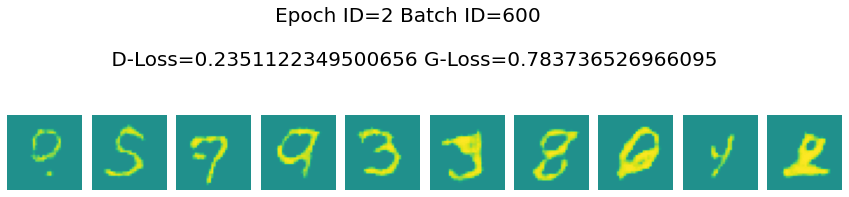

Epoch ID=2 Batch ID=700 

 D-Loss=0.20709678530693054 G-Loss=1.7983344793319702


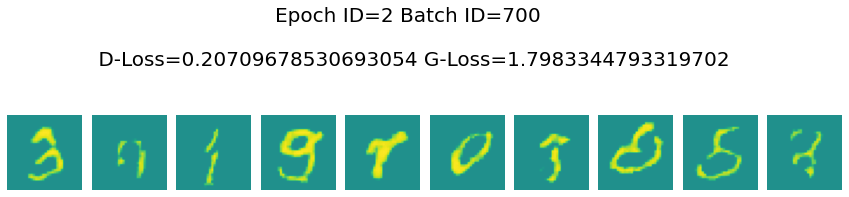

Epoch ID=2 Batch ID=800 

 D-Loss=0.38120368123054504 G-Loss=0.17089729011058807


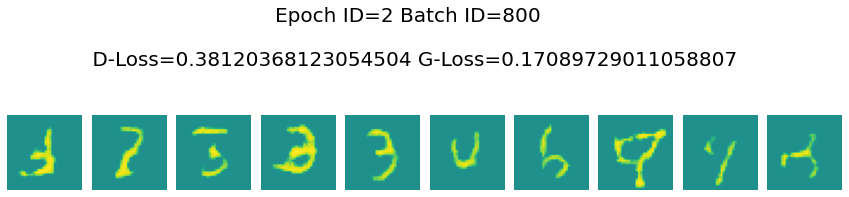

Epoch ID=2 Batch ID=900 

 D-Loss=0.16527853906154633 G-Loss=0.6017712950706482


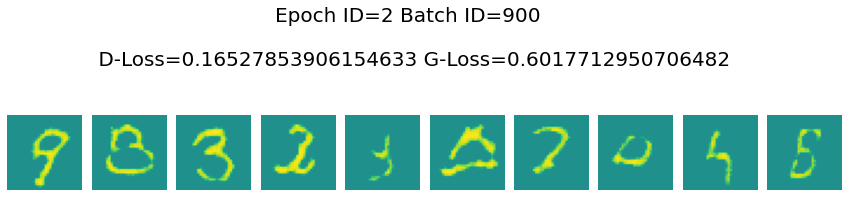

Epoch ID=2 Batch ID=1000 

 D-Loss=0.19217929244041443 G-Loss=0.6019058227539062


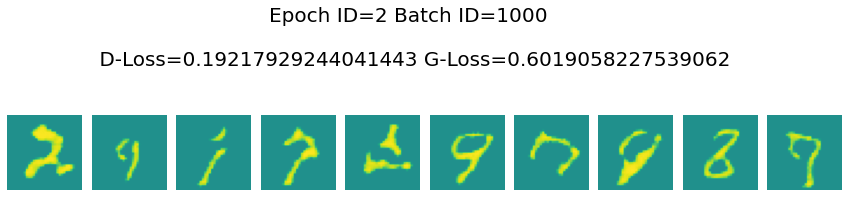

Epoch ID=2 Batch ID=1100 

 D-Loss=0.11788995563983917 G-Loss=0.7467588186264038


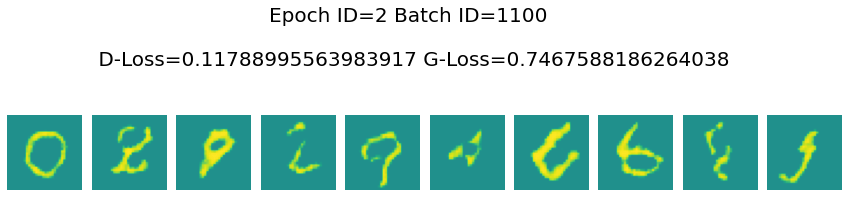

Epoch ID=2 Batch ID=1200 

 D-Loss=0.13550448417663574 G-Loss=0.6771748661994934


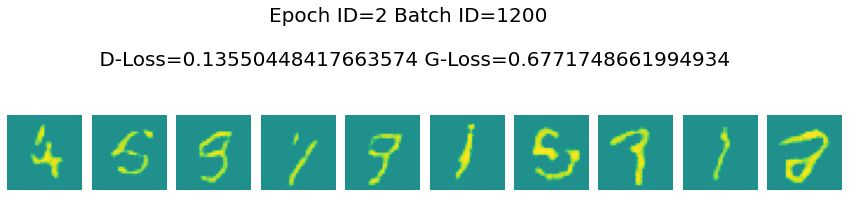

Epoch ID=2 Batch ID=1300 

 D-Loss=0.24761219322681427 G-Loss=0.34776145219802856


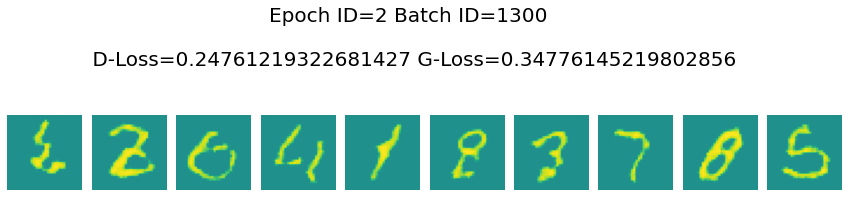

Epoch ID=2 Batch ID=1400 

 D-Loss=0.14967429637908936 G-Loss=0.39709049463272095


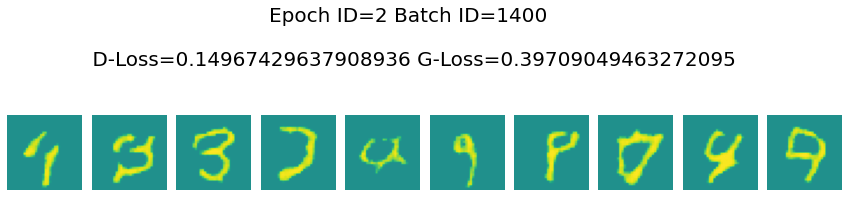

Epoch ID=2 Batch ID=1500 

 D-Loss=0.1331034004688263 G-Loss=0.5724712610244751


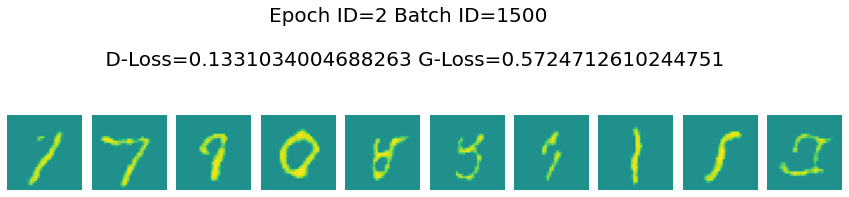

Epoch ID=2 Batch ID=1600 

 D-Loss=0.34603458642959595 G-Loss=0.20551523566246033


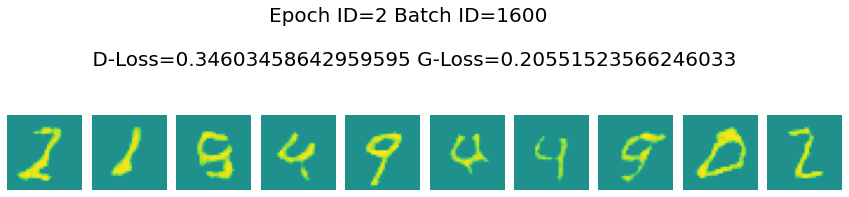

Epoch ID=2 Batch ID=1700 

 D-Loss=0.5006245374679565 G-Loss=0.182630717754364


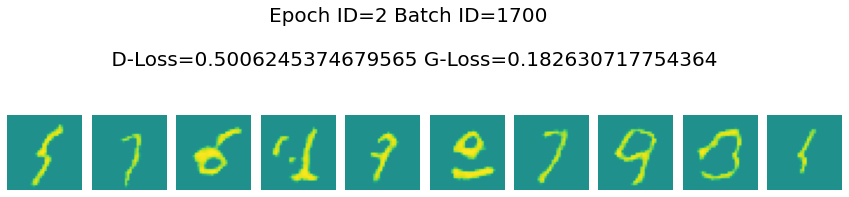

Epoch ID=2 Batch ID=1800 

 D-Loss=0.16533589363098145 G-Loss=0.9038212299346924


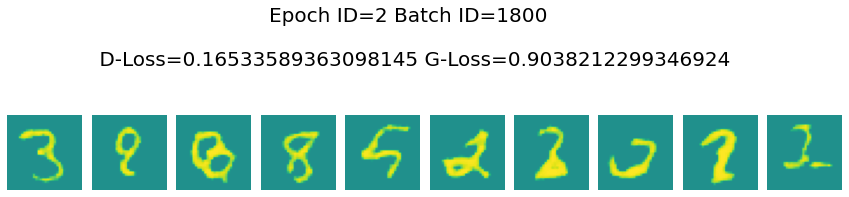

Epoch ID=3 Batch ID=0 

 D-Loss=0.09138223528862 G-Loss=0.5405009984970093


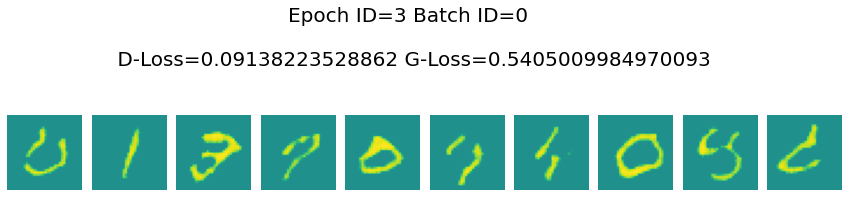

Epoch ID=3 Batch ID=100 

 D-Loss=0.18548482656478882 G-Loss=0.9832640290260315


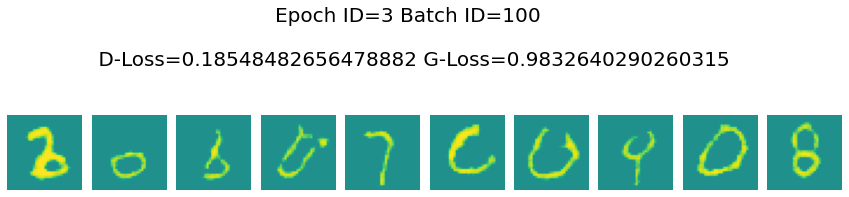

Epoch ID=3 Batch ID=200 

 D-Loss=0.10967996716499329 G-Loss=0.632131040096283


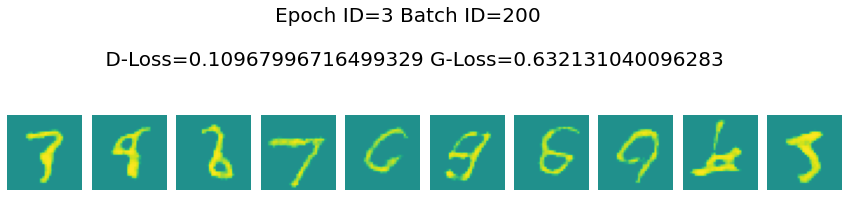

Epoch ID=3 Batch ID=300 

 D-Loss=0.2792872488498688 G-Loss=0.8158154487609863


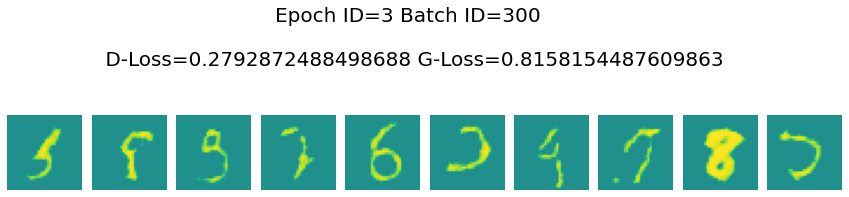

Epoch ID=3 Batch ID=400 

 D-Loss=0.46960514783859253 G-Loss=0.3713533282279968


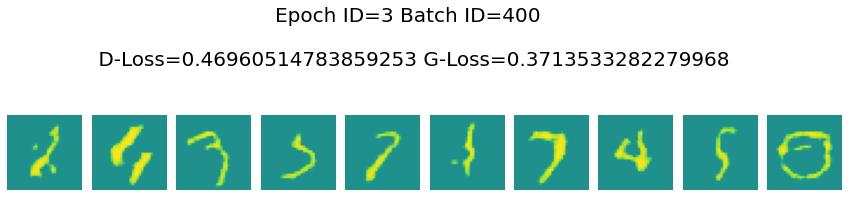

Epoch ID=3 Batch ID=500 

 D-Loss=0.08612210303544998 G-Loss=0.8518412709236145


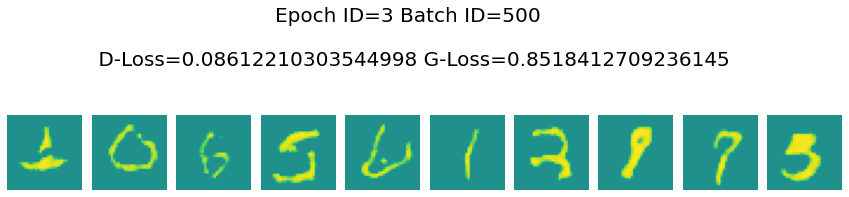

Epoch ID=3 Batch ID=600 

 D-Loss=0.1706521362066269 G-Loss=0.35886621475219727


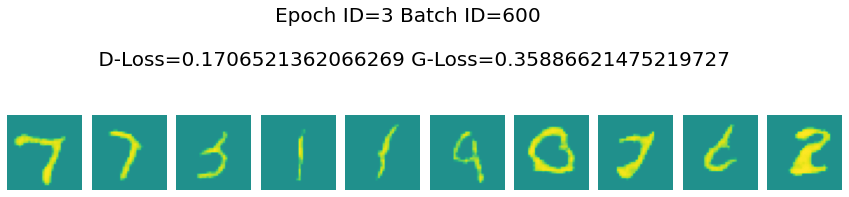

Epoch ID=3 Batch ID=700 

 D-Loss=0.21550728380680084 G-Loss=0.7840818166732788


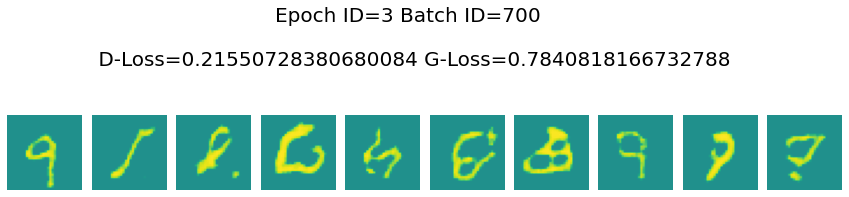

Epoch ID=3 Batch ID=800 

 D-Loss=0.19235903024673462 G-Loss=0.7768410444259644


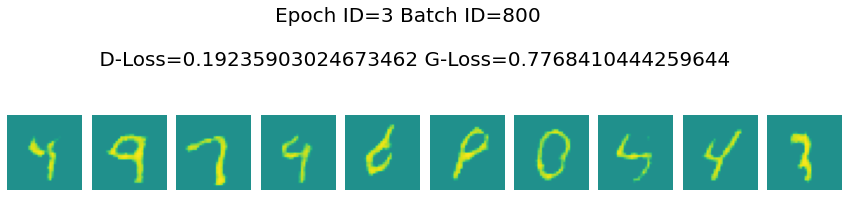

Epoch ID=3 Batch ID=900 

 D-Loss=0.1867522895336151 G-Loss=0.8397821187973022


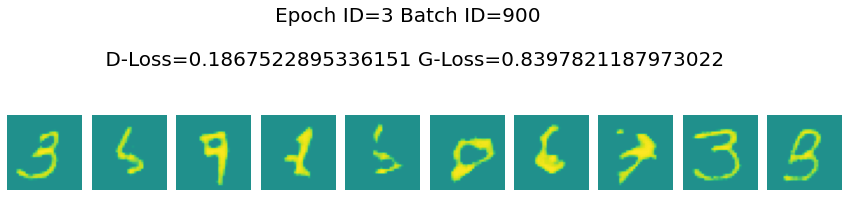

Epoch ID=3 Batch ID=1000 

 D-Loss=0.27722835540771484 G-Loss=0.5028319358825684


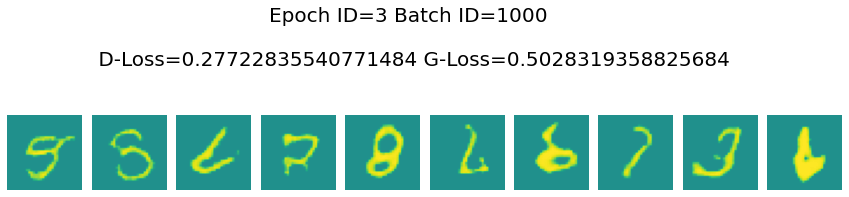

Epoch ID=3 Batch ID=1100 

 D-Loss=0.08193948864936829 G-Loss=0.6901073455810547


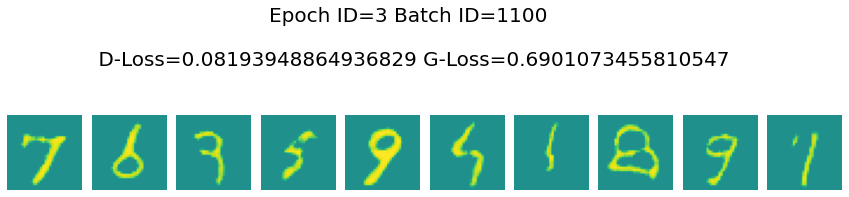

Epoch ID=3 Batch ID=1200 

 D-Loss=0.16661521792411804 G-Loss=0.46801328659057617


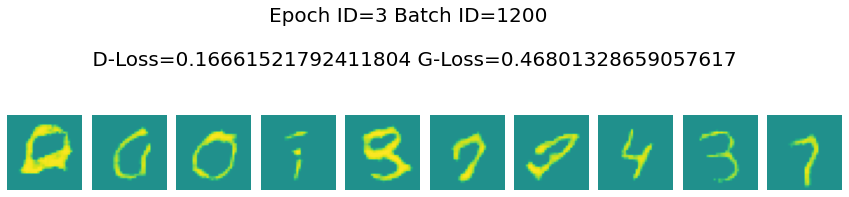

Epoch ID=3 Batch ID=1300 

 D-Loss=0.25122660398483276 G-Loss=0.6375577449798584


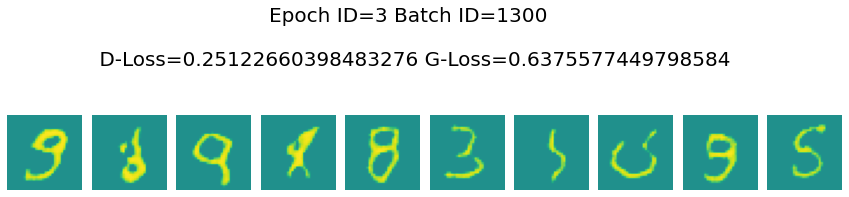

Epoch ID=3 Batch ID=1400 

 D-Loss=0.10142196714878082 G-Loss=0.9458876848220825


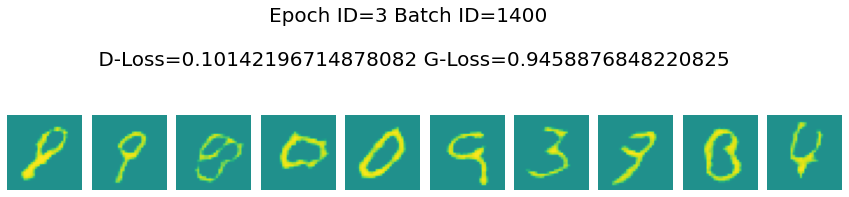

Epoch ID=3 Batch ID=1500 

 D-Loss=0.20835091173648834 G-Loss=0.4819604158401489


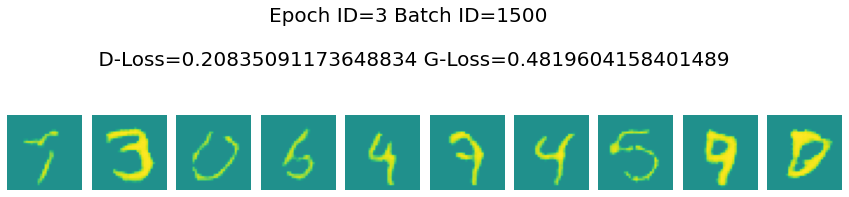

Epoch ID=3 Batch ID=1600 

 D-Loss=0.4922444820404053 G-Loss=0.25002098083496094


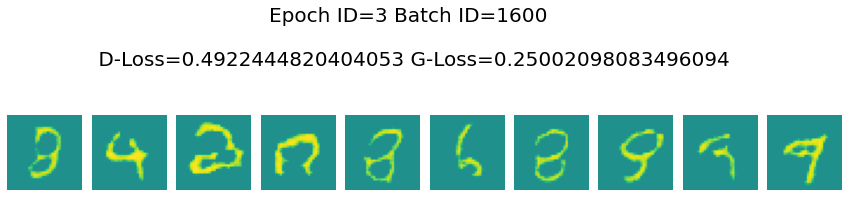

Epoch ID=3 Batch ID=1700 

 D-Loss=0.22715160250663757 G-Loss=0.3411369025707245


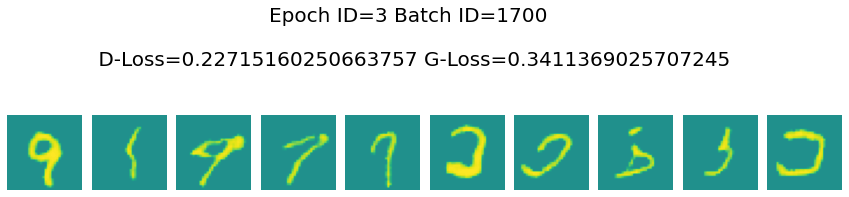

Epoch ID=3 Batch ID=1800 

 D-Loss=0.088056281208992 G-Loss=0.6260643005371094


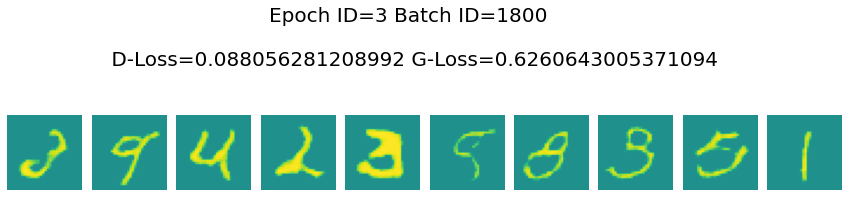

Epoch ID=4 Batch ID=0 

 D-Loss=0.18982230126857758 G-Loss=0.6907700896263123


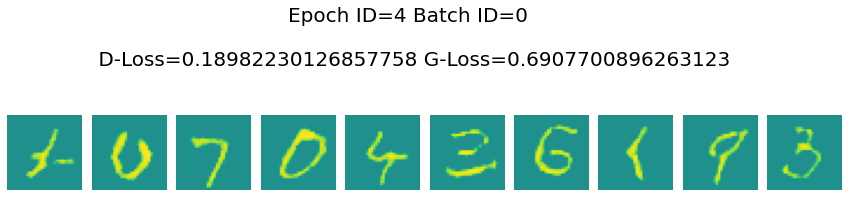

Epoch ID=4 Batch ID=100 

 D-Loss=0.2393525093793869 G-Loss=0.539024829864502


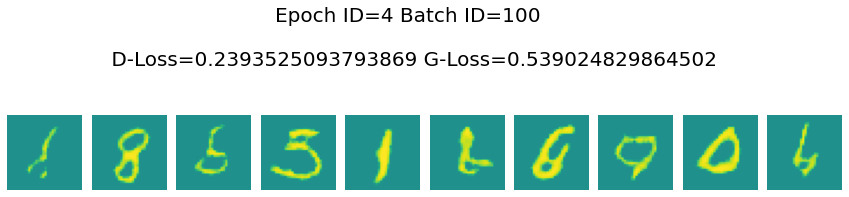

Epoch ID=4 Batch ID=200 

 D-Loss=0.11461203545331955 G-Loss=0.530059814453125


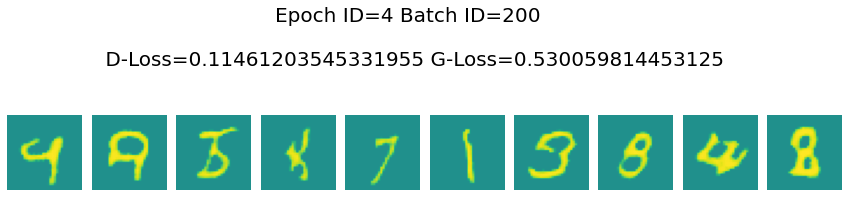

Epoch ID=4 Batch ID=300 

 D-Loss=0.10038064420223236 G-Loss=0.8573758602142334


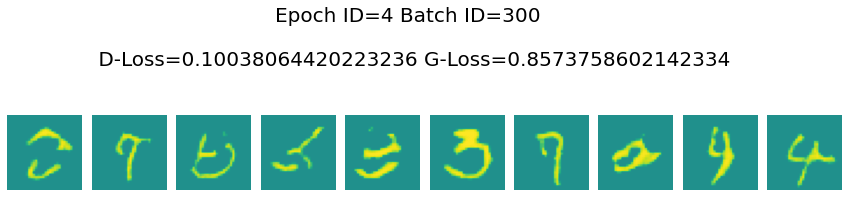

Epoch ID=4 Batch ID=400 

 D-Loss=0.15367768704891205 G-Loss=1.1269781589508057


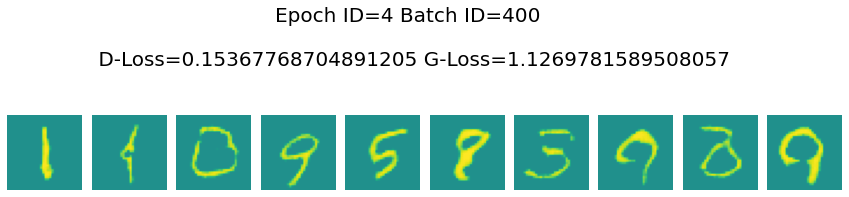

Epoch ID=4 Batch ID=500 

 D-Loss=0.10796233266592026 G-Loss=0.6717020273208618


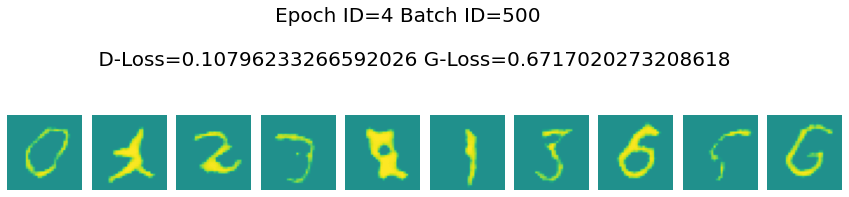

Epoch ID=4 Batch ID=600 

 D-Loss=0.1510981023311615 G-Loss=0.46135401725769043


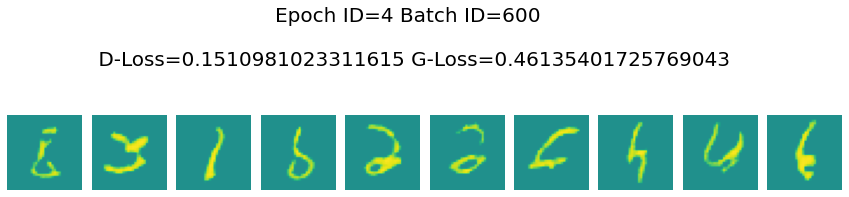

Epoch ID=4 Batch ID=700 

 D-Loss=0.10136187821626663 G-Loss=0.9023923873901367


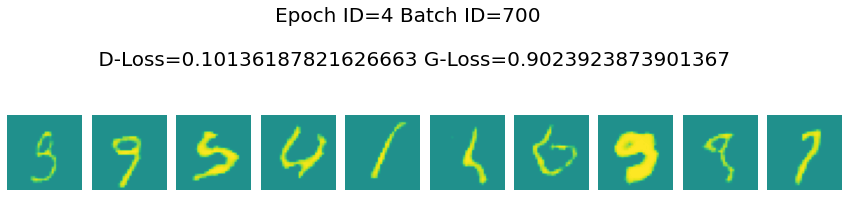

Epoch ID=4 Batch ID=800 

 D-Loss=0.2914441227912903 G-Loss=1.8121421337127686


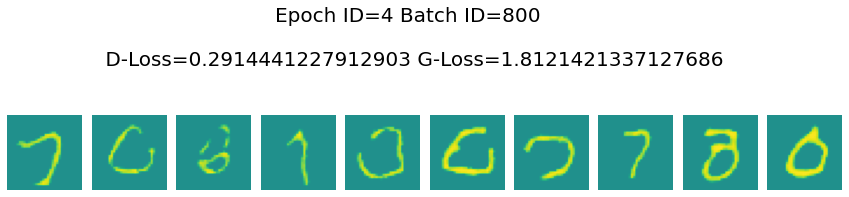

Epoch ID=4 Batch ID=900 

 D-Loss=0.16763122379779816 G-Loss=0.5421550869941711


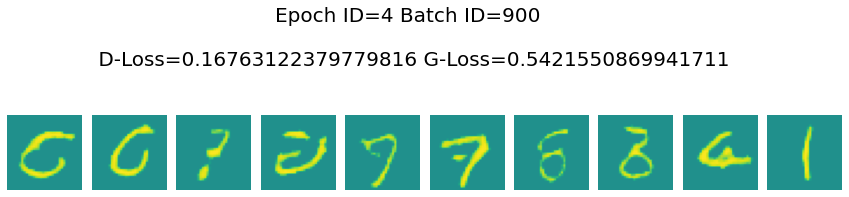

Epoch ID=4 Batch ID=1000 

 D-Loss=0.12904614210128784 G-Loss=0.6261152029037476


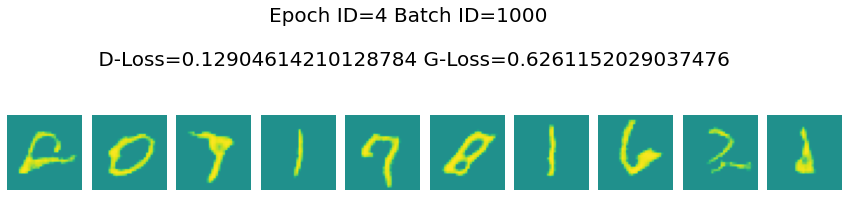

Epoch ID=4 Batch ID=1100 

 D-Loss=0.3001556396484375 G-Loss=1.3463196754455566


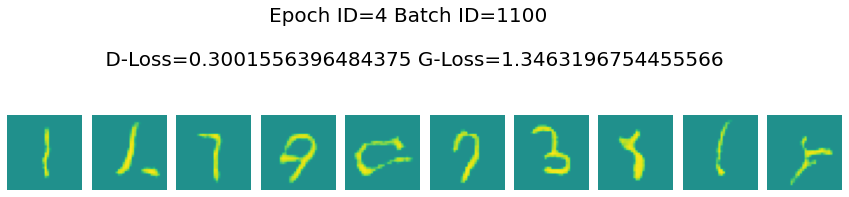

Epoch ID=4 Batch ID=1200 

 D-Loss=0.14120379090309143 G-Loss=1.0949549674987793


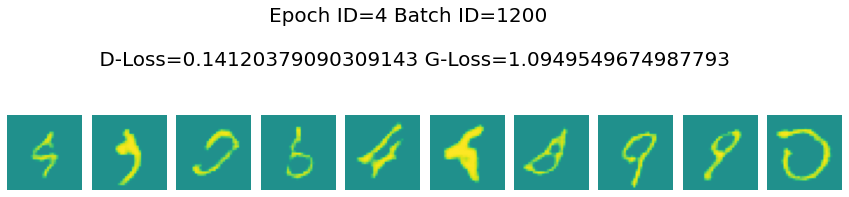

Epoch ID=4 Batch ID=1300 

 D-Loss=0.046467125415802 G-Loss=1.044813632965088


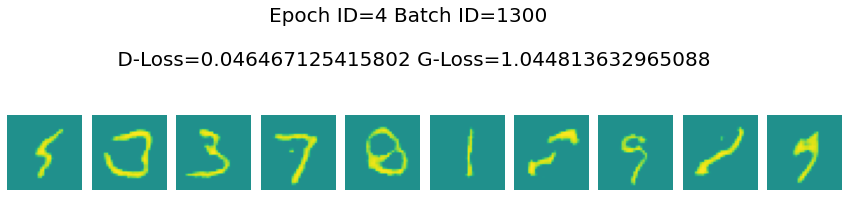

Epoch ID=4 Batch ID=1400 

 D-Loss=0.10744664072990417 G-Loss=0.9112403392791748


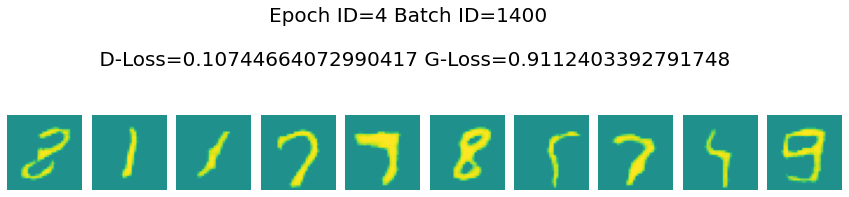

Epoch ID=4 Batch ID=1500 

 D-Loss=0.06690764427185059 G-Loss=0.9052906632423401


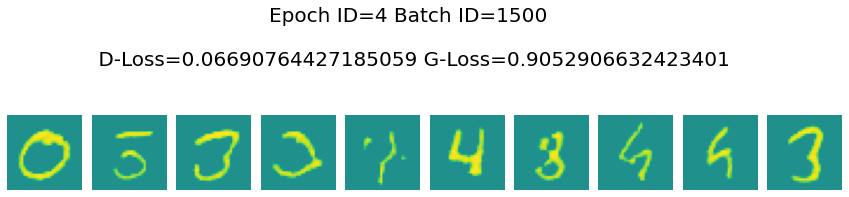

Epoch ID=4 Batch ID=1600 

 D-Loss=0.09278347343206406 G-Loss=0.5219410061836243


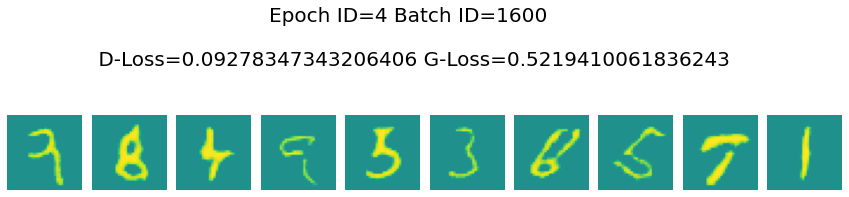

Epoch ID=4 Batch ID=1700 

 D-Loss=0.06589443236589432 G-Loss=0.886770486831665


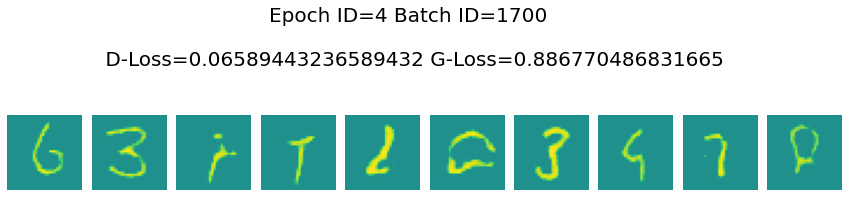

Epoch ID=4 Batch ID=1800 

 D-Loss=0.09010320901870728 G-Loss=1.3126468658447266


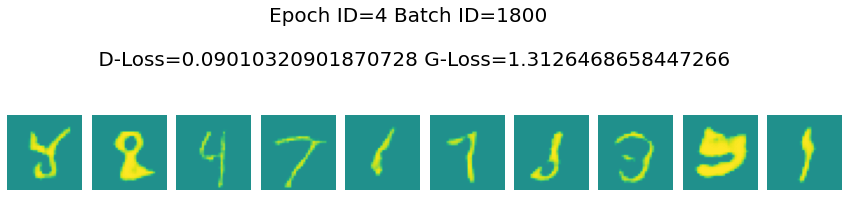

In [24]:
losses = [[], []]
now = 0 
for epoch in range(5):
    for batch_id, (img, _) in enumerate(dataloader):
        # fixed G-net, optimize D-net, dst: max V(D, G) = Ex[log(D(x))] + Ex[1-logD(G(x))] => D(x) -> 1, D(G(x)) -> 0
        optimizerD.clear_grad()
        real_img = img
        batch_size = img.shape[0]
        # 真实图片
        label = paddle.full((batch_size, 1, 1, 1), real_label, dtype='float32')
        real_out = netD(real_img)
        errD_real = loss(real_out, label)
        
        # 初始随机噪声,引导生成图片 (100 dim)
        noise = paddle.randn((batch_size, 100, 1, 1), dtype='float32')
        fake_img = netG(noise)
        label = paddle.full((batch_size, 1, 1, 1), fake_label, dtype='float32')
        fake_out = netD(fake_img.detach())
        errD_fake = loss(fake_out, label)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        losses[0].append(errD.numpy()[0])
        
        # fixed D-net, optimize G-net, dst: min V(D, G)=Ex[log(1-D(G(x)))]  =>  D(G(x)) -> 1 
        optimizerG.clear_grad()
        noise = paddle.randn((batch_size, 100, 1, 1), dtype='float32')
        fake_img = netG(noise)
        label = paddle.full((batch_size, 1, 1, 1), 1, dtype='float32')
        out = netD(fake_img)
        errG = loss(out, label)
        errG.backward()
        optimizerG.step()
        losses[1].append(errG.numpy()[0])
        
        ############################
        # visualize
        ###########################
        if batch_id % 100 == 0:
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,0,2))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(epoch, batch_id, errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', epoch, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
        paddle.save(netG.state_dict(), "work/generator.params")